In [1]:
# !!!!!!!!!!!!!!!!!!!!downloaded sam with pip install, look in the reademe for more info!!!!!!!!!!!!!!!!!

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2
import matplotlib.pyplot as plt
import numpy as np
import yaml

In [2]:
sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")

In [3]:
import cv2
import numpy as np

def resize_image(img, new_width):

    # Get the original image size
    height, width, _ = img.shape

    # Calculate the aspect ratio
    ratio = new_width / width

    # Calculate the new height with the aspect ratio
    new_height = int(height * ratio)

    # Resize the image
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Return the resized image as a numpy array
    return np.array(resized_img)

In [4]:
image = cv2.imread('mini_testdatensatz/train/picture_1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = resize_image(image, 192)

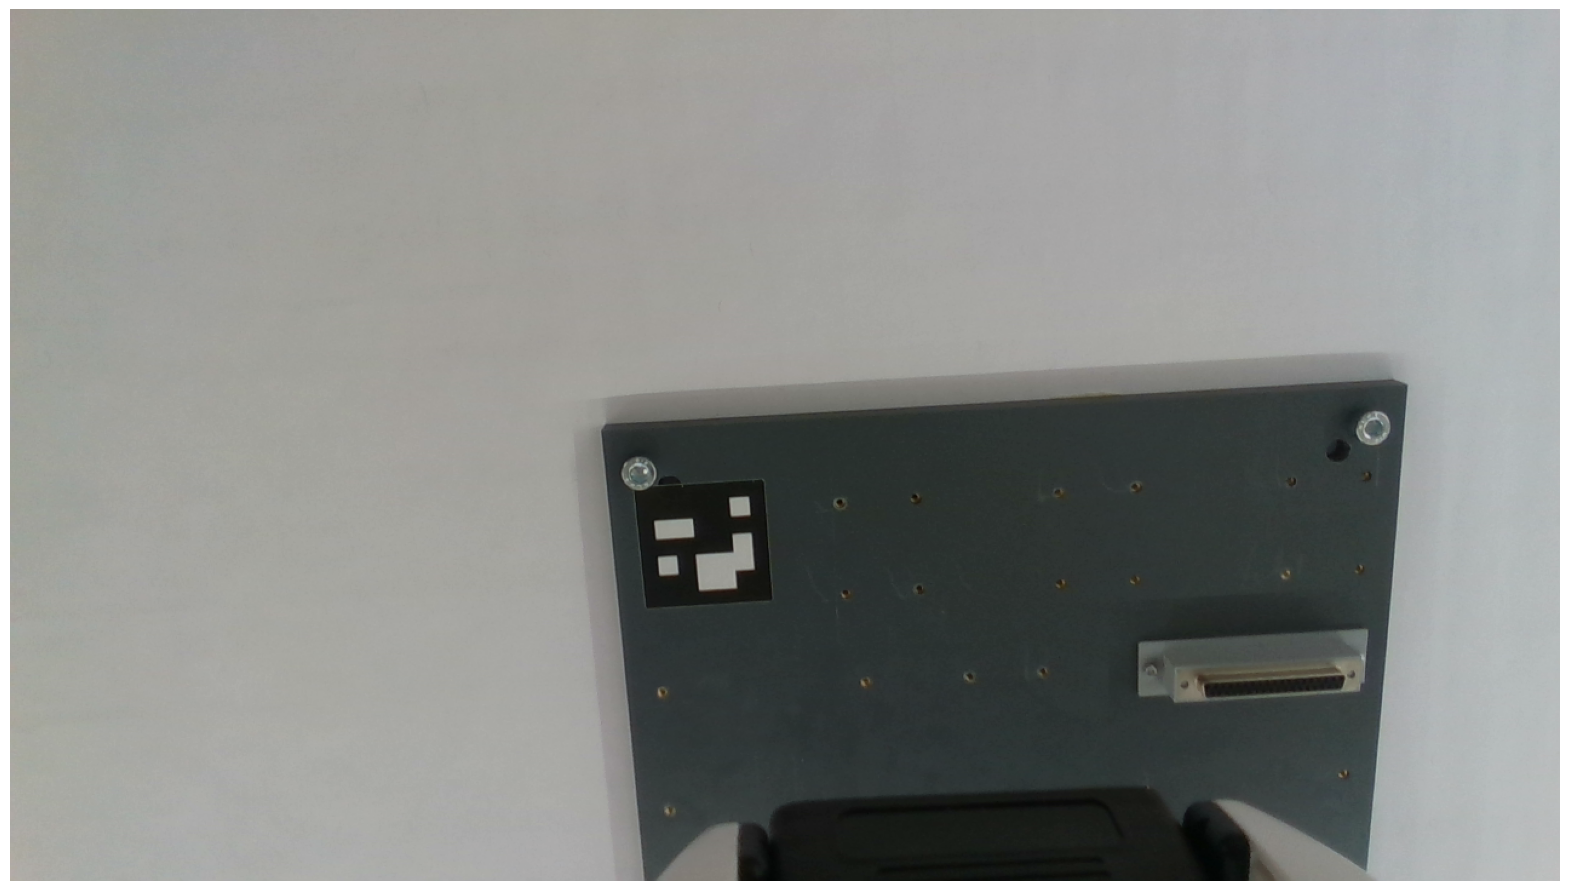

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

In [7]:
print(masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [10]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    colors = []
    with open('colors.yaml', 'r') as f:
        colors = yaml.safe_load(f)
    color_index = 0
    for ann in sorted_anns:
        m = ann['segmentation'] # m is a binary mask
        print("Area" , ann['area']) # Area is the number of true pixels in the mask
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = colors[color_index]
        color_index = (color_index + 1) % len(colors) # cycle through colors if more than len(colors) annotations
        print(color_mask)
        for i in range(3):
            img[:,:,i] = color_mask[i] / 255.0 # normalize RGB values to range [0,1]
        #ax.imshow(np.dstack((img, m*0.35)))
        ax.imshow(np.dstack((img,0.8*m)))

Area 663631
[0, 255, 255]
Area 212743
[255, 0, 0]
Area 34881
[0, 255, 0]
Area 34596
[0, 0, 255]
Area 24047
[255, 255, 0]
Area 15501
[255, 0, 255]
Area 15458
[0, 0, 0]
Area 10594
[255, 128, 0]
Area 9557
[255, 255, 255]
Area 9167
[128, 0, 255]
Area 4015
[128, 255, 0]
Area 3006
[0, 255, 128]
Area 2652
[0, 128, 255]
Area 2234
[255, 128, 128]
Area 1522
[128, 255, 128]
Area 1221
[128, 128, 255]
Area 708
[192, 192, 192]
Area 552
[128, 128, 128]
Area 282
[64, 64, 64]
Area 282
[255, 0, 128]
Area 143
[0, 255, 255]
Area 122
[255, 0, 0]
Area 119
[0, 255, 0]
Area 102
[0, 0, 255]
Area 102
[255, 255, 0]
Area 95
[255, 0, 255]
Area 76
[0, 0, 0]


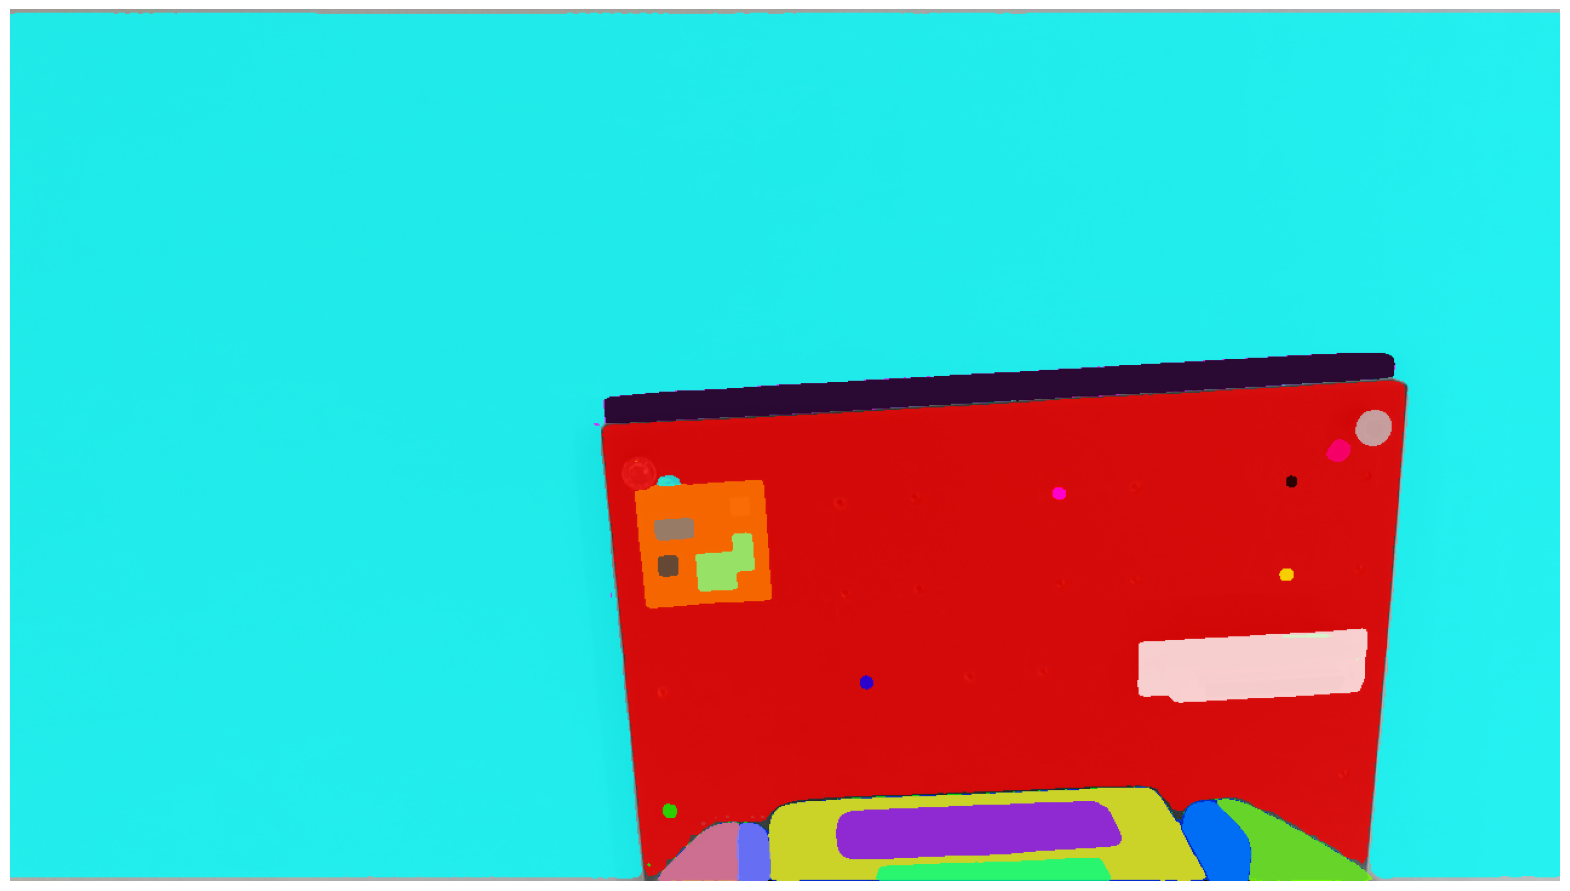

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 